## Data description

1. timestamp
2. cnt – The count of bike shares
3. t1 – Real temperature in Celsius
4. t2 – Temperature in Celsius “feels like”
5. hum – Humidity in percentage
6. wind_speed – Wind speed in km/h
7. weather_code – Weather category
8. is_holiday – Boolean, 1-holiday
9. is_weekend – Boolean, 1-weekend
10. season – Categorical: 0-spring, 1-summer, 2-fall, 3-winter

** The cnt column is going to be our target for prediction

## Importing Liblaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  tensorflow as tf
import seaborn as sns
import sklearn.preprocessing

In [2]:
df=pd.read_csv('london_merged.csv',parse_dates=['timestamp'],
               index_col="timestamp")

In [3]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
df.shape

(17414, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [6]:
df.columns

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season'],
      dtype='object')

In [7]:
df.dtypes

cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [8]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen

johan_test_temp = df
coint_johansen(johan_test_temp,-1,1).eig

array([2.61219379e-01, 1.31970167e-01, 5.22046139e-02, 4.19830465e-02,
       2.10126207e-02, 1.75450605e-02, 1.36518877e-02, 6.26085775e-04,
       7.56291478e-05])

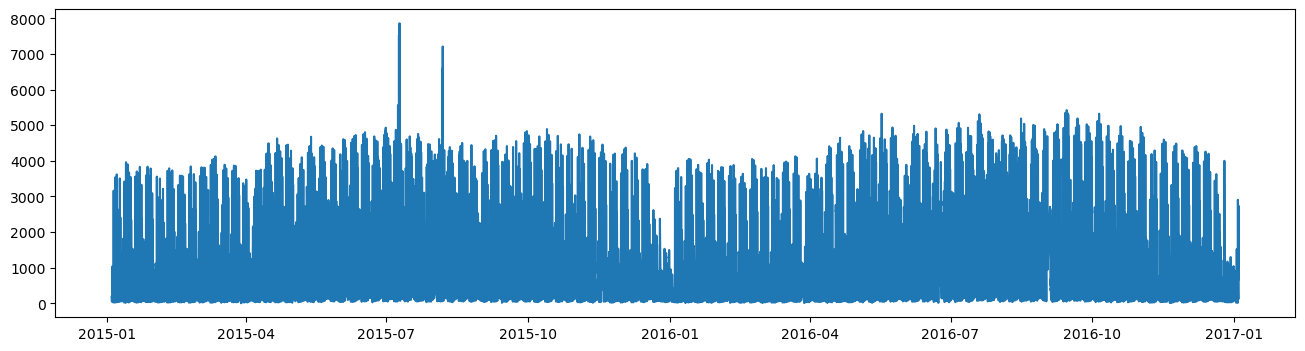

In [9]:
## Exploring data
plt.figure(figsize=(16,4))
plt.plot(df.index,df["cnt"])

In [10]:
# Create indexes
df['hour'] = df.index.hour
df['month'] = df.index.month

<Axes: xlabel='month', ylabel='cnt'>

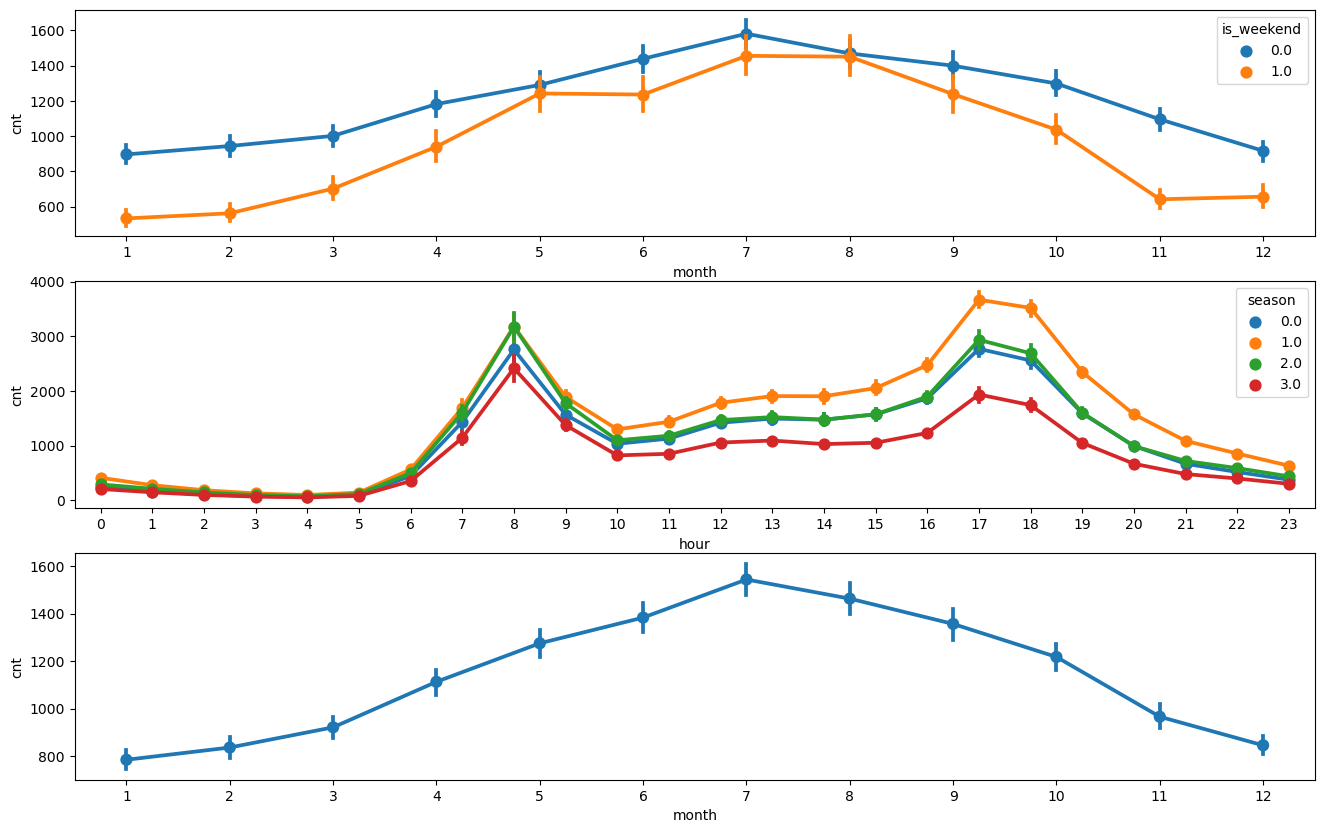

In [11]:
# creating plots using the inices created
fig,(ax1, ax2, ax3)= plt.subplots(nrows = 3)
fig.set_size_inches(16, 10)
sns.pointplot(data = df, x = 'month', y = 'cnt',hue = 'is_weekend', ax = ax1)
sns.pointplot(data = df, x = 'hour', y = 'cnt',hue = 'season', ax = ax2);
sns.pointplot(data = df, x = 'month', y = 'cnt',ax = ax3)

## Data preparation

In [12]:
# scaling numeric columns
scaler = sklearn.preprocessing.MinMaxScaler()
df['t1'] = scaler.fit_transform(df['t1'].values.reshape(-1,1))
df['t2'] = scaler.fit_transform(df['t2'].values.reshape(-1,1))
df['hum'] = scaler.fit_transform(df['hum'].values.reshape(-1,1))
df['wind_speed'] = scaler.fit_transform(df['wind_speed'].values.reshape(-1,1))
df['cnt'] = scaler.fit_transform(df['cnt'].values.reshape(-1,1))

In [13]:
# use 90% for training
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
    

In [14]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
time_steps = 10
X_train, y_train =create_dataset(train, train.cnt, time_steps)
X_test, y_test =create_dataset(test, test.cnt, time_steps)

In [16]:
batch_size = 256
buffer_size = 1000
train_data = tf.data.Dataset.from_tensor_slices((X_train , y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
test_data = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_data = test_data.batch(batch_size).repeat()

## Creating Model

In [17]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape = X_train.shape[-2:]),
    tf.keras.layers.Dense(1)])
simple_lstm_model.compile(optimizer = 'adam', loss = 'mae')

C:\Users\Brian\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training

In [18]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
history = simple_lstm_model.fit(train_data,
                                epochs = EPOCHS,
                                steps_per_epoch = EVALUATION_INTERVAL,
                                validation_data = test_data,
                                validation_steps = 50
                               )

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5169 - val_loss: 0.0754
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0825 - val_loss: 0.0649
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0701 - val_loss: 0.0565
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0654 - val_loss: 0.0547
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0580 - val_loss: 0.0480
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0529 - val_loss: 0.0435
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0481 - val_loss: 0.0419
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0459 - val_loss: 0.0414
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0448 - val_loss: 0.0405
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0409 - val_loss: 0.0394


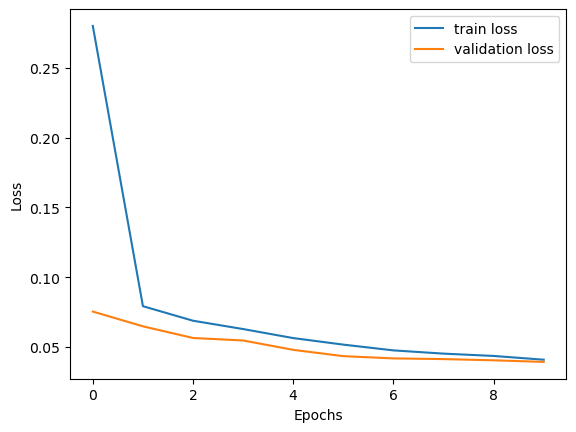

In [19]:
# plot losses
plt.plot(history.history['loss'],label = 'train loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Evaluation

In [20]:
X_test,y_test = create_dataset(df,df.cnt,10)
y_pred = simple_lstm_model.predict(X_test)

544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [21]:
def create_time_steps(length):
    return list(range(-length, 0))

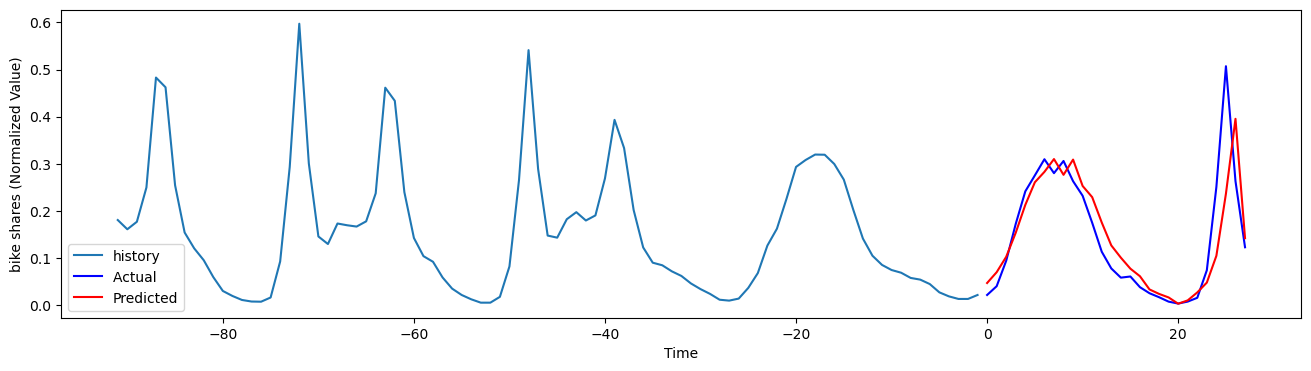

In [22]:
plt.figure(figsize = (16,4))
num_in = create_time_steps(91)
num_out = 28
plt.plot(num_in,y_train[15571:],label = 'history')
plt.plot(np.arange(num_out),y_test[15661:15689], 'b',label='Actual ')
plt.plot(np.arange(num_out),y_pred[15661:15689], 'r',label = 'Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()

## Predicting Future Point

In [23]:
y_pred = simple_lstm_model.predict(X_test[-1:])
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([[0.03444836]], dtype=float32)

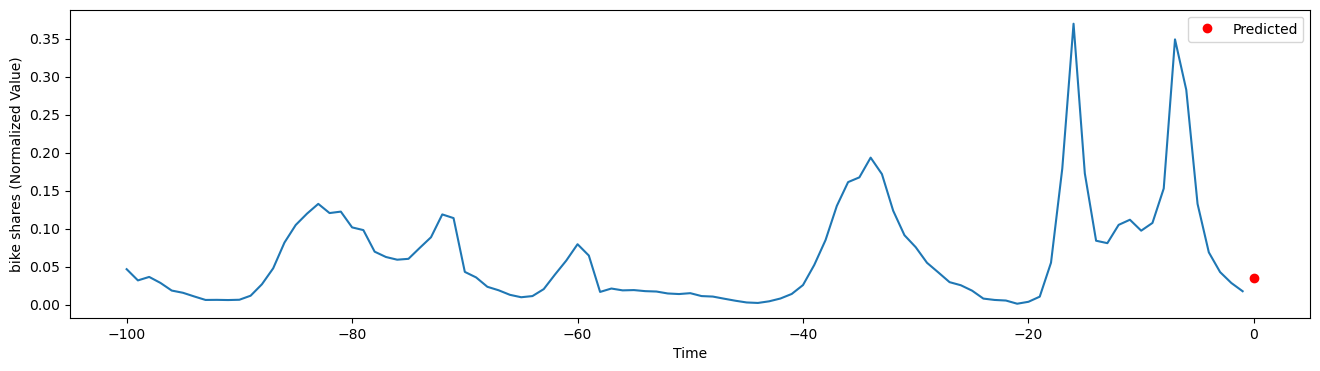

In [24]:
# plot prediction
# plot prediction
plt.figure(figsize = (16,4))
num_in = create_time_steps(100)
num_out = 1
plt.plot(num_in,y_test[-100:])
plt.plot(np.arange(num_out),y_pred, 'ro',label = 'Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()

## Predicting Range of Data Points

In [25]:
df2 = df['2017-01-03 14:00:00':'2017-01-03 23:00:00']

In [26]:
df1 = df['2016-01-04 00:00:00':'2016-01-06 23:00:00']

In [27]:
df1['cnt'] = 0
df_future = df2.append(df1, sort = False)
df_future

C:\Users\Brian\AppData\Local\Temp\ipykernel_9184\1431954192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cnt'] = 0
C:\Users\Brian\AppData\Local\Temp\ipykernel_9184\1431954192.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_future = df2.append(df1, sort = False)


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month
timestamp,,,,,,,,,,,
2017-01-03 14:00:00,0.097328,0.211268,0.2000,0.666667,0.389381,3.0,0.0,0.0,3.0,14,1
2017-01-03 15:00:00,0.107506,0.211268,0.2000,0.635220,0.477876,4.0,0.0,0.0,3.0,15,1
2017-01-03 16:00:00,0.152799,0.211268,0.2000,0.635220,0.460177,4.0,0.0,0.0,3.0,16,1
2017-01-03 17:00:00,0.348855,0.211268,0.2000,0.666667,0.371681,3.0,0.0,0.0,3.0,17,1
2017-01-03 18:00:00,0.282443,0.183099,0.1750,0.761006,0.389381,2.0,0.0,0.0,3.0,18,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-06 19:00:00,0.000000,0.239437,0.3000,0.874214,0.123894,2.0,0.0,0.0,3.0,19,1
2016-01-06 20:00:00,0.000000,0.239437,0.3000,0.836478,0.115044,2.0,0.0,0.0,3.0,20,1
2016-01-06 21:00:00,0.000000,0.211268,0.2625,0.911950,0.115044,2.0,0.0,0.0,3.0,21,1


In [29]:
df_future = df_future.reset_index(drop = True)

In [31]:
predictions = []
# make prediction in a loop every time adding the last prediction
for i in range(50):
    X_f, y_f = create_dataset(df_future, df_future.cnt, time_steps)
    y_pred = simple_lstm_model.predict(X_f[i:i+1])
    df_future['cnt'][i+10] = y_pred
    predictions.append(float(y_pred[0][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\Brian\AppData\Local\Temp\ipykernel_9184\3821831986.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_future['cnt'][i+10] = y_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

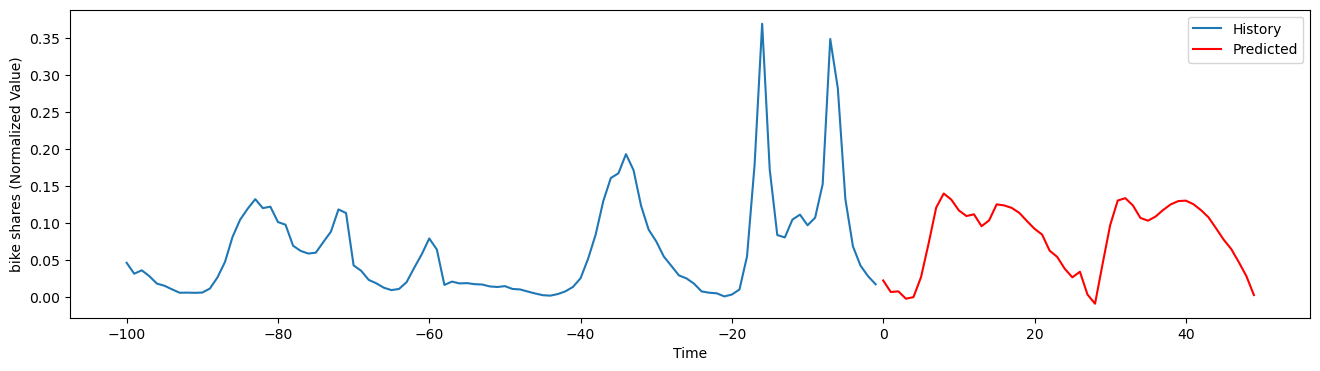

In [32]:
plt.figure(figsize = (16,4))
num_in = create_time_steps(100)
num_out = 50
plt.plot(num_in,y_test[-100:],label = 'History')
plt.plot(np.arange(num_out),predictions, 'r',label = 'Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()